In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import pickle
import bz2
import time


In [3]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [4]:
from src.wikipreprocess import WikiPreprocess
from helpers.log import setUpNewLogFile

# Load datapickle 
From wikidownloader.py

In [5]:
print('Load data pickle')
with bz2.BZ2File('../data/datapicklesoup.bz2', 'rb') as f:  #Use datacompression BZ2
    data= pickle.load(f)
print('Loaded data pickle')
    
df = pd.DataFrame({'text':data[0],'title':data[1]})

Load data pickle
Loaded data pickle


In [6]:
#remove zero length articles
articlelen=df.text.apply(len)
df=df[articlelen>10]

# Preprocessing documents
### Tokenizing and removing stop words


In [7]:
data = df.text.values
wiki_pp = WikiPreprocess()

In [8]:
starttime = time.time()
preprocessed_data =  [wiki_pp.preprocess_document(text=d, min_token_len=4) for d in data]
print('Preprocessing took = {:.0f} minutes'.format((time.time()-starttime)/60.0))

print(preprocessed_data[0])

['megacraspedus', 'cuencellus', 'moth', 'family', 'gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'third', 'apex', 'hindwings', 'mouse', 'grey']


In [9]:
id2word = wiki_pp.create_dictionary(preprocessed_data)
texts = preprocessed_data
corpus = wiki_pp.articles_to_bow(id2word, texts)
print([(id2word[id], freq) for id, freq in corpus[0]][:20])
print(corpus[0]) #it will print the corpus we created above.

[('apex', 1), ('aristide', 1), ('caradja', 1), ('cuencellus', 1), ('described', 1), ('family', 1), ('forewings', 1), ('found', 1), ('france', 1), ('gelechiidae', 1), ('grey', 2), ('hindwings', 1), ('margin', 1), ('megacraspedus', 1), ('moth', 1), ('mouse', 2), ('spain', 1), ('third', 1), ('uniform', 1), ('whitish', 1)]
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1)]


# Adding bigrams

In [10]:
data_words_bigrams = wiki_pp.make_bigrams(preprocessed_data)
print(data_words_bigrams[0])

['megacraspedus', 'cuencellus', 'moth_family', 'gelechiidae_described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'third', 'apex_hindwings', 'mouse', 'grey']


# Lemmatization

Reference: https://www.researchgate.net/publication/341574872_Machine_Learning_and_Deep_Neural_Network-Based_Lemmatization_and_Morphosyntactic_Tagging_for_Serbian


The basic set of PoS-categories/tags that should be as-signed to tokens is not generally accepted, even for a speciﬁc language. The choice of a tagset usually depends on the foreseen task or project. A tagset tailored to be applicable for PoS-tagging in general is the Universal Part-of-Speech (UPoS) tagset (Petrov et al., 2012) (used by spaCy), and it lists the following 17 categories: adjective(ADJ), adposition (ADP), adverb (ADV), auxiliary (AUX),coordinating conjunction (CCONJ), determiner (DET), interjection (INTJ), noun (N), numerical (NUM), particle(PART), pronoun (PRON), proper noun (PROPN), punctuation (PUNCT), subordinating conjunction (SCONJ), symbol (SYM), verb (VERB) and other (X). It should be notedthat the MULTEXT-East tagset (Erjavec, 2012) was alsotailored to be universal. SMD uses its own tagset thatcorresponds closely to Serbian traditional grammars. TheSerbian TreeTagger models TT11 and TT19 (see Subsec-tion 3.3.) use modiﬁcations of the SMD tagset. A gen-eral overview of the tagsets used is presented in Table 3.It should be noted that tags for some PoS differ betweentagsets (e.g. ADJ in UPoS vs. A in SMD for adjective

In [ ]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
doc = nlp(" ".join(data_words_bigrams[0]))

In [11]:
tags = []
for w in doc:
    if not w.pos_ in tags:
        print('Lemmatization Example {} -> {}'.format(w.lemma_,w.pos_))
        tags.append(w.pos_)
tags

Lemmatization Example megacraspedus -> PROPN
Lemmatization Example cuencellus -> VERB
Lemmatization Example margin -> NOUN
Lemmatization Example whitish -> ADJ


['PROPN', 'VERB', 'NOUN', 'ADJ']

In [12]:
# lemmatize bigrams

# data_lemmatized = [wiki_pp.lemmatize(d, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) for d in data_words_bigrams]

# read in data due to run time
with bz2.BZ2File('../data/lemmatized_bigrams.bz2', 'rb') as f:  #Use datacompression BZ2
    data_lemmatized = pickle.load(f)

In [13]:
print(data_lemmatized[0])

['megacraspedus', 'cuencellus', 'moth_family', 'gelechiidae_describe', 'find', 'forewing', 'margin', 'mouse']


In [14]:
print(data_words_bigrams[0])

['megacraspedus', 'cuencellus', 'moth_family', 'gelechiidae_described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'third', 'apex_hindwings', 'mouse', 'grey']


# Creating bag of words frequencies

#### Without Lemmatization

In [15]:
id2word = wiki_pp.create_dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = wiki_pp.articles_to_bow(id2word, texts)
print(corpus[0][:20]) #it will print the corpus we created above.
[(id2word[id], freq) for id, freq in corpus[0]][:20]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1)]


[('apex_hindwings', 1),
 ('aristide', 1),
 ('caradja', 1),
 ('cuencellus', 1),
 ('forewings', 1),
 ('found', 1),
 ('france', 1),
 ('gelechiidae_described', 1),
 ('grey', 2),
 ('margin', 1),
 ('megacraspedus', 1),
 ('moth_family', 1),
 ('mouse', 2),
 ('spain', 1),
 ('third', 1),
 ('uniform', 1),
 ('whitish', 1)]

In [16]:
print(f'Number of unique tokens: {len(id2word)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 368500
Number of documents: 49835


#### With Lemmatization

In [17]:
# Filter out words that occur less than X documents, 
# or more than X% of the documents.
id2word_lemmatized = wiki_pp.filtered_dictionary(data_lemmatized, no_below=10, no_above=0.1)
corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in data_lemmatized]
print(corpus_lemmatized[0]) #it will print the corpus we created above.
[(id2word_lemmatized[id], freq) for id, freq in corpus_lemmatized[0]]
# print the words with their frequencies.


[(0, 1), (1, 1), (2, 1), (3, 1)]


[('forewing', 1), ('margin', 1), ('moth_family', 1), ('mouse', 1)]

In [18]:
print(f'Number of unique tokens: {len(id2word_lemmatized)}')
print(f'Number of documents: {len(corpus_lemmatized)}')

Number of unique tokens: 25995
Number of documents: 49835


In [19]:
dictwords=set(id2word_lemmatized.values())

In [20]:
data_lemmatized_filtered=[[w for w in article if w in dictwords] for article in data_lemmatized]

# Fitting via LDA Variational Inference (Gensim) library

About Gensim algorithmn

The core estimation code is based on the `onlineldavb.py script

    https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    Matthew D. Hoffman, David M. Blei, Francis Bach:
    
Online Learning for Latent Dirichlet Allocation', NIPS 2010

    Hoffman et al.: online-lda_
    https://papers.neurips.cc/paper/2010/file/71f6278d140af599e06ad9bf1ba03cb0-Paper.pdf


![title](LDAVI-Algo1.PNG)

EM Algorihmn explanation (General):

Given the statistical model which generates a set X  of observed data, a set of unobserved latent data or missing values Z , and a vector of unknown parameters theta, along with a likelihood function

    First, initialize the parameters theta to some random values.
    Compute the probability of each possible value of Z  , given theta
    Then, use the just-computed values of Z  to compute a better estimate for the parameters theta
    Iterate steps 2 and 3 until convergence.

Specifically for LDA:

    X = w is the corpus we see
    Z = phi φ (per word topic assignments) and gamma γ (topic assignment)
    theta = λ (topic distribution)

E step:
Based on topic distribution 

There are K topics.

theta, $\theta$ is the topic distribution for each document

beta, $\beta$ is the word distribution for each topic. $\lambda$ is the associated variational parameter.

z is the per-word assignments. φ is the associated variational paramter.

γi and φi are per document variational parameters

q(zdi = k) = φdwdik; q(θd) = Dirichlet(θd; γd); q(βk) = Dirichlet(βk; λk),

## Running LDA without lemmatized data

In [21]:
starttime=time.time()
setUpNewLogFile('gensim_nolem.log')

lda_model = gensim.models.ldamulticore.LdaMulticore(
   corpus=corpus, id2word=id2word, num_topics=20, random_state=100, 
   eval_every=1000, chunksize=200, passes=20, alpha='symmetric', per_word_topics=True
)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 16 minutes


#### Evaluate model

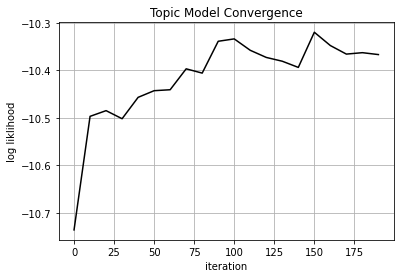

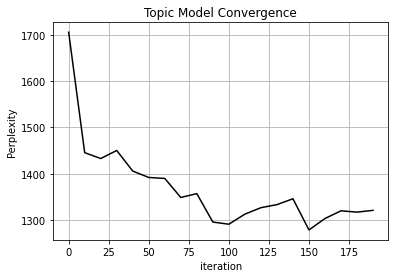

Note: Perplexity estimate based on a held-out corpus of 4 documents


In [22]:
p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_nolem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter[:-1],liklihood[:-1],c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()


plt.plot(iter[:-1],perplexity[:-1],c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Perplexity estimate based on a held-out corpus of 4 documents')

In [23]:
print('\nLog Likelihood(per-word ELBO): ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(
   model=lda_model, texts=texts, dictionary=id2word, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Log Likelihood(per-word ELBO):  -10.612686502293144

Coherence Score:  0.507727955773074


## With Lemmatization (using lemmatized corpus & dictionary)

In [24]:
starttime=time.time()
setUpNewLogFile('gensim_lem.log')

lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
   corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=20, random_state=100, 
   eval_every=1000, chunksize=1000, passes=10, alpha='symmetric', per_word_topics=True
)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 1 minutes


#### Evaluate model

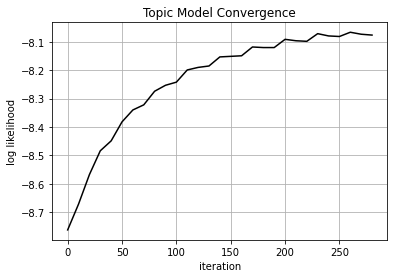

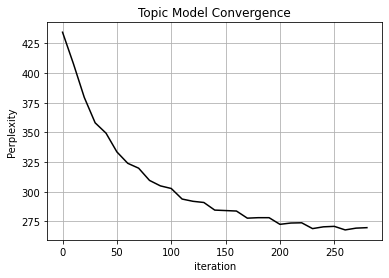

Note: Log likelihood is per-word ELBO
Note: Perplexity estimate based on a held-out corpus of 4 documents


In [25]:
p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_lem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter[:-1],liklihood[:-1],c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()


plt.plot(iter[:-1],perplexity[:-1],c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Log likelihood is per-word ELBO')
print('Note: Perplexity estimate based on a held-out corpus of 4 documents')


In [26]:
print('\nLog Likelihood(per-word ELBO): ', lda_model_lemmatized.log_perplexity(corpus_lemmatized))
coherence_model_lda_lemmatized = CoherenceModel(
   model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
)
coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
print('\nCoherence Score: ', coherence_lda_lemmatized)




Log Likelihood(per-word ELBO):  -8.064564534634528

Coherence Score:  0.6196128154160183


# About how gensim reports perplexity
https://tedboy.github.io/nlps/_modules/gensim/models/ldamodel.html#LdaModel.log_perplexity

    They calculate the ELBO of the variational inferred q vs p in function "bound"
    
        def bound(self, corpus, gamma=None, subsample_ratio=1.0):
            Estimate the variational bound of documents from `corpus`:
            E_q[log p(corpus)] - E_q[log q(corpus)]
        
    Then they divide the ELBO by the number of words/tokens so that it is "per-word".
    The likelihood reported above is the per-word likelihood, and perplexity=2^(-bound)
        
        def log_perplexity(self, chunk, total_docs=None):
            Calculate and return per-word likelihood bound, using the `chunk` of
            documents as evaluation corpus. Also output the calculated statistics. incl.
            perplexity=2^(-bound), to log at INFO level.

# Parameter tuning
### Choosing number of topics

In [27]:
K_Coherence={}
models={}
for K in [5,10,15,20,25,30,40]:
    print('Starting K={}'.format(K))
    starttime=time.time()
    setUpNewLogFile('gensim_lem.log'.format(K))

    #New code uses multicore which runs works in parallel for each CPU core.
    lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
       corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=K, random_state=100, 
       eval_every=1000, chunksize=1000, passes=8, alpha='symmetric', per_word_topics=True
    )
    coherence_model_lda_lemmatized = CoherenceModel(
       model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
    )
    coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
    print('Coherence Score: ', coherence_lda_lemmatized)
    K_Coherence[K]=coherence_lda_lemmatized
    print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))
    models[K]=lda_model_lemmatized

Starting K=5
Coherence Score:  0.5287872455305243
Time taken = 1 minutes
Starting K=10
Coherence Score:  0.580707406637143
Time taken = 1 minutes
Starting K=15
Coherence Score:  0.5561010159443074
Time taken = 2 minutes
Starting K=20
Coherence Score:  0.6087118043546612
Time taken = 2 minutes
Starting K=25
Coherence Score:  0.5878044864013158
Time taken = 3 minutes
Starting K=30
Coherence Score:  0.586498365758993
Time taken = 2 minutes
Starting K=40
Coherence Score:  0.5811384923587151
Time taken = 3 minutes


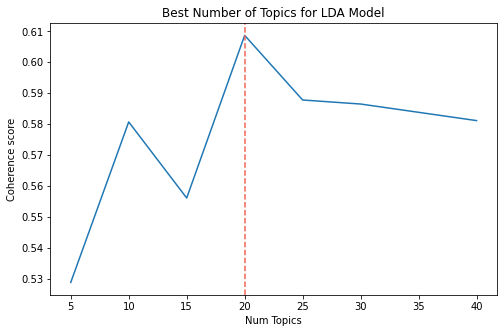

In [28]:
plt.figure(figsize=(8,5))

x = list(K_Coherence.keys())
coherence_values= list(K_Coherence.values())

# Build the line plot
#ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')
ax=plt.plot(x,coherence_values)

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')

# Exploring final model (with Lemmatization)

In [29]:
#Choose model with K=20
lda_model_lemmatized=models[20]

In [30]:
pprint(lda_model_lemmatized.print_topics())

[(0,
  '0.006*"force" + 0.006*"government" + 0.006*"military" + 0.006*"german" + '
  '0.005*"order" + 0.004*"king" + 0.004*"attack" + 0.004*"army" + 0.004*"kill" '
  '+ 0.004*"battle"'),
 (1,
  '0.020*"station" + 0.017*"line" + 0.012*"service" + 0.010*"railway" + '
  '0.009*"aircraft" + 0.008*"operate" + 0.008*"train" + 0.006*"design" + '
  '0.006*"engine" + 0.006*"vehicle"'),
 (2,
  '0.010*"student" + 0.009*"system" + 0.009*"program" + 0.007*"research" + '
  '0.007*"university" + 0.006*"service" + 0.006*"provide" + 0.005*"technology" '
  '+ 0.005*"information" + 0.005*"education"'),
 (3,
  '0.005*"displaystyle" + 0.005*"system" + 0.004*"cell" + 0.004*"example" + '
  '0.004*"result" + 0.004*"type" + 0.004*"case" + 0.004*"function" + '
  '0.003*"cause" + 0.003*"study"'),
 (4,
  '0.014*"village" + 0.014*"population" + 0.013*"district" + 0.011*"town" + '
  '0.010*"river" + 0.009*"county" + 0.007*"water" + 0.007*"land" + '
  '0.007*"region" + 0.006*"park"'),
 (5,
  '0.008*"government" + 0.

In [31]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmatized, corpus_lemmatized, id2word_lemmatized)
vis

/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.039197  0.095049       1        1  9.342979
3      0.159377 -0.020139       2        1  7.498010
0      0.017744  0.053480       3        1  7.116579
4      0.106059 -0.123452       4        1  6.656099
5      0.059118  0.076110       5        1  6.611153
15     0.054732  0.159874       6        1  6.543634
12    -0.059414  0.083762       7        1  6.219888
2      0.086980  0.032305       8        1  6.131777
9      0.072506 -0.060076       9        1  5.404282
18    -0.224754 -0.041846      10        1  4.928467
6     -0.027886  0.106074      11        1  4.594571
1      0.058839 -0.172919      12        1  4.311610
19    -0.051704  0.062678      13        1  3.985773
11    -0.046035 -0.114103      14        1  3.503394
17     0.010213  0.098452      15        1  3.351065
8      0.101408 -0.095214      16        1  3.232916
14    -0.162168 -0.070461      17        1  3.138388
7      0.001024 -0.065471      18        1  2.997835
10    -0.171293 -0.051304      19        1  2.696640
13     0.054450  0.047202      20        1  1.734939, topic_info=               Term          Freq         Total Category  logprob  loglift
930            game  16995.000000  16995.000000  Default  30.0000  30.0000
921            film  20237.000000  20237.000000  Default  29.0000  29.0000
115          season  16704.000000  16704.000000  Default  28.0000  28.0000
1387          album  11006.000000  11006.000000  Default  27.0000  27.0000
104          player   8971.000000   8971.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
873          design    394.425051   9059.057204  Topic20  -5.5822   0.9201
964   international    335.618865   7714.518301  Topic20  -5.7437   0.9193
1106         studio    279.664428   2953.619270  Topic20  -5.9261   1.6970
67            study    292.543904  10024.903915  Topic20  -5.8810   0.5200
286           often    258.790327   6350.206759  Topic20  -6.0036   0.8540

[1786 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
4293       1  0.030966  abortion
4293       2  0.019056  abortion
4293       3  0.002382  abortion
4293       4  0.002382  abortion
4293       5  0.797981  abortion
...      ...       ...       ...
325       20  0.020541     young
11412      1  0.892753    zombie
11412      7  0.085263    zombie
11412     19  0.005015    zombie
11412     20  0.005015    zombie

[16212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 4, 1, 5, 6, 16, 13, 3, 10, 19, 7, 2, 20, 12, 18, 9, 15, 8, 11, 14])

/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/anthonylimon/Desktop/DSC180B/DSC180B-LDACode/env/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for al